In [11]:
# Source: https://scikit-gstat.readthedocs.io/en/latest/userguide/kriging.html
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import skgstat as skg
from scipy.spatial.distance import *

In [12]:
# Location
x = np.array([4.0, 2.0, 4.1, 0.3, 2.0])
y = np.array([5.5, 1.2, 3.7, 2.0, 2.5])

# Observation
z = np.array([4.2, 6.1, 0.2, 0.7, 5.2])
s0 = [2., 2.]

distance_matrix = pdist([s0] + list(zip(x,y)))
display(distance_matrix)
squareform(distance_matrix)

array([4.03112887, 0.8       , 2.70185122, 1.7       , 0.5       ,
       4.74236228, 1.80277564, 5.09313263, 3.60555128, 3.26496554,
       1.87882942, 1.3       , 4.16293166, 2.41867732, 1.77200451])

array([[0.        , 4.03112887, 0.8       , 2.70185122, 1.7       ,
        0.5       ],
       [4.03112887, 0.        , 4.74236228, 1.80277564, 5.09313263,
        3.60555128],
       [0.8       , 4.74236228, 0.        , 3.26496554, 1.87882942,
        1.3       ],
       [2.70185122, 1.80277564, 3.26496554, 0.        , 4.16293166,
        2.41867732],
       [1.7       , 5.09313263, 1.87882942, 4.16293166, 0.        ,
        1.77200451],
       [0.5       , 3.60555128, 1.3       , 2.41867732, 1.77200451,
        0.        ]])

In [8]:
# Build a variogram
from skgstat.models import spherical
model = lambda h: spherical(h, 7.0, 2.0, 0.0)

In [9]:
# calculate the variogram based on the Euclidean distance
# basically a function of the first distance between s0 and the other 5 points
variances = model(distance_matrix[:5])
variances

array([1.53664752, 0.34136443, 1.10043328, 0.71424781, 0.21392128])

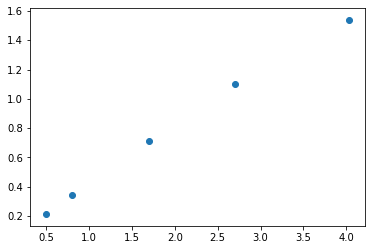

In [10]:
plt.scatter(distance_matrix[:5], variances)

Quote from the source:
Of course we could now <b> use </b> the inverse of these semi-variances to weigh the observations, but that would <b> not be correct </b>. Remeber, that this array variances is what we want the target weights to incorporte. <br>
At the same time, the five points among each other also have distances and therefore variances that <b> should be respected </b>. <br>
ie:Take the first observation point s1. The associated variances γ to the other four points need to match the one just calculated. <br>

so we have a system of linear equation for this.

In [17]:
dists = pdist(list(zip(x,y)))
M = squareform(model(dists))

print(M)
print(variances)
print(M.shape, len(variances))

[[0.         1.72149133 0.75553644 1.79759369 1.40858271]
 [1.72149133 0.         1.29780001 0.78587655 0.55073761]
 [0.75553644 1.29780001 0.         1.57378236 0.9953245 ]
 [1.79759369 0.78587655 1.57378236 0.         0.74320866]
 [1.40858271 0.55073761 0.9953245  0.74320866 0.        ]]
[1.53664752 0.34136443 1.10043328 0.71424781 0.21392128]
(5, 5) 5


In [16]:
from scipy.linalg import solve

# Solve the linear equation to have the weights
a = solve(M, variances)

# estimation
z.dot(a)

5.226267185422778

In [22]:
# However, we want to add another constraint: 
# the weight needs to sum to 1

B = np.concatenate((variances, [1]))
M = squareform(model(dists))
M = np.concatenate((M, [[1, 1, 1, 1, 1]]), axis=0)
M = np.concatenate((M, [[1], [1], [1], [1], [1], [0]]), axis=1)
print(M)
print(B)
weights = solve(M, B)

[[0.         1.72149133 0.75553644 1.79759369 1.40858271 1.        ]
 [1.72149133 0.         1.29780001 0.78587655 0.55073761 1.        ]
 [0.75553644 1.29780001 0.         1.57378236 0.9953245  1.        ]
 [1.79759369 0.78587655 1.57378236 0.         0.74320866 1.        ]
 [1.40858271 0.55073761 0.9953245  0.74320866 0.         1.        ]
 [1.         1.         1.         1.         1.         0.        ]]
[1.53664752 0.34136443 1.10043328 0.71424781 0.21392128 1.        ]


In [23]:
# Getting rid of the last calculated value
print("New weights", weights[:-1])

New weights [-0.01711142  0.36476979  0.01998039  0.0405826   0.59177864]


In [25]:
print("New estimation: ", z.dot(weights[:-1]))

New estimation:  5.2628805787423785


In the last step, we introduced a factor μ. It was needed to solve the linear equation system while assuring that the weights sum up to one. <br>
ie, it is the <b> Lagrange Multipler</b> of an optimization problem <br>
This factor can in turn be <b>added</b> to the weighted target semi-variances used to build the equation system, to obtain the <b> Kriging error </b> (likely some kind of fitting error).

In [29]:
display(M.dot(weights) - B)
display(B[:-1] * weights[:-1])

array([ 0.00000000e+00,  1.11022302e-16,  0.00000000e+00,  0.00000000e+00,
       -2.77555756e-17,  0.00000000e+00])

array([-0.02629423,  0.12451943,  0.02198709,  0.02898604,  0.12659405])

The Kriging error of this particular point. A Higher error => more uncertainty

In [30]:
sum(B[:-1] * weights[:-1]) + weights[-1]

0.2628757539286831

if $ weight = 0 $ => no randomness. This point is a linear interpolation of the other point